In [5]:
import anatomist.api as ana
from soma.qt_gui.qtThread import QtThreadCall
from soma.qt_gui.qt_backend import Qt

from soma import aims
import numpy as np
import pandas as pd
import os
import glob

import matplotlib.pyplot as plt

In [6]:
%matplotlib qt5
a = ana.Anatomist()

In [7]:
path = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0_trained_on_UKB40/SC-sylv_right"
lab = "gravityCenter_y"
model_path = glob.glob(f"{path}/*")[0]
embeddings_file = f"{model_path}/hcp_random_epoch80_embeddings/full_embeddings.csv"
participants_file = "/neurospin/dico/data/human/hcp/derivatives/morphologist-2023/morphometry/spam_recognition/morpho_talairach/morpho_S.C._right.dat"
mm_skeleton_path = "/neurospin/dico/jchavas/Runs/70_self-supervised_two-regions/Output/realigned/SCsylv-right/7_no_alignment"

In [8]:
participants = pd.read_csv(participants_file, sep=' ', index_col=0)
participants = participants[[lab]].dropna()
participants

,gravityCenter_y
subject,
100206,23.6737
100307,17.6998
100408,20.6022
100610,20.0265
101006,18.7678
...,...
992774,18.2473
993675,18.7725
994273,19.0850


In [9]:
ukb_emb = pd.read_csv(f"{embeddings_file}", index_col=0)
merged = participants[[lab]].merge(ukb_emb, left_index=True, right_index=True)
label = merged.iloc[:,0:1]
label.head()

,gravityCenter_y
subject,
100206,23.6737
100307,17.6998
100408,20.6022
100610,20.0265
101006,18.7678


### Variable definitions

In [10]:
side = "R" # "R" or "L"
region = "S.C.-sylv." # "ORBITAL", "CINGULATE", "SC-sylv", "F.I.P."
database='hcp'

In [11]:
# %matplotlib inline
# df[["p"]].plot.hist()
# plt.show()

### Function definitions

In [12]:
def to_bucket(obj):
    if obj.type() == obj.BUCKET:
        return obj
    avol = a.toAimsObject(obj)
    c = aims.Converter(intype=avol, outtype=aims.BucketMap_VOID)
    abck = c(avol)
    bck = a.toAObject(abck)
    bck.releaseAppRef()
    return bck

def build_gradient(pal):
    gw = ana.cpp.GradientWidget(None, 'gradientwidget', pal.header()['palette_gradients'])
    gw.setHasAlpha(True)
    nc = pal.shape[0]
    rgbp = gw.fillGradient(nc, True)
    rgb = rgbp.data()
    npal = pal.np['v']
    pb = np.frombuffer(rgb, dtype=np.uint8).reshape((nc, 4))
    npal[:, 0, 0, 0, :] = pb
    npal[:, 0, 0, 0, :3] = npal[:, 0, 0, 0, :3][:, ::-1]  # BGRA -> RGBA
    pal.update()

def buckets_average(subject_id_list, dataset_name_list):
    # here datset_name_list not used
    dic_vol = {}
    dim = 0
    rep = 0
    if len(subject_id_list) == 0:
        return False
    while rep < len(subject_id_list):
        # if dataset_name_list[rep].lower() in ['ukb', 'ukbiobank', 'projected_ukb']:
        #     dataset = 'UkBioBank'
        # elif dataset_name_list[rep].lower() in ['hcp']:
        #     dataset = 'hcp'
        if os.path.isfile(f'{mm_skeleton_path}/after_cropped{subject_id_list[rep]}.nii.gz'):
            sum_vol = aims.read(f'{mm_skeleton_path}/after_cropped{subject_id_list[rep]}.nii.gz').astype(float)
            dim = sum_vol.shape
            sum_vol.fill(0)
        else: 
            print(f'FileNotFound {mm_skeleton_path}/after_cropped{subject_id_list[rep]}.nii.gz')
        rep += 1

    for subject_id, dataset in zip(subject_id_list,dataset_name_list):
        # if dataset.lower() in ['ukb', 'ukbiobank',  'projected_ukb']:
        #     dataset = 'UkBioBank'
        # elif dataset.lower() == 'hcp':
        #     dataset = 'hcp'

        if os.path.isfile(f'{mm_skeleton_path}/after_cropped{subject_id}.nii.gz'):
            vol = aims.read(f'{mm_skeleton_path}/after_cropped{subject_id}.nii.gz')
            # compare the dim with the first file dim

            if vol.np.shape != dim:
                raise ValueError(f"{subject_id_list[0]} and {subject_id} must have the same dim")

                
            # to have a binary 3D structure
            dic_vol[subject_id] = (vol.np > 0).astype(int)
            sum_vol.np[:] += (vol.np > 0).astype(int) 
        else: 
            print(f'FileNotFound {mm_skeleton_path}/after_cropped{subject_id_list[rep]}.nii.gz')

    sum_vol = sum_vol / len(subject_id_list)
    print(sum_vol.np.sum(), sum_vol.shape, len(subject_id_list))
    return sum_vol

In [13]:
def visualize_averages_along_parameter(df, column_name, database, nb_subjects_per_average=200, nb_columns=3, nb_lines=1):
    # anatomist objects
    global _block
    global _average_dic
    nb_windows = nb_columns * nb_lines
    _average_dic = {}
    step = nb_subjects_per_average # number of subjects on which average is done
    # Creates the block if it has not been created
    try:
        _block
    except NameError:
        _block = a.createWindowsBlock(nb_columns)

    # Order according to column_name
    df = df.sort_values(column_name, ascending=False)
    predict_proba = df[[column_name]]

    # Creates dictionary of subjects to average
    dic_packages = {}
    for i in range(0,len(predict_proba),step):
        list_idx = (predict_proba.index[i:i+step].to_numpy())
        dic_packages[i//step] = list_idx
    list_database = [database for i in range(step)]
    n_pack = len(dic_packages)

    # Loop of display averages
    list_pack = [int(np.ceil(i*n_pack/float(nb_windows))) for i in range(0,nb_windows)]
    print(len(df), list_pack, dic_packages[0])
    sum_vol_list = []
    for i in list_pack:
        sum_vol_list.append(buckets_average(dic_packages[i], list_database))
        _average_dic[f'a_sum_vol{i}'] = a.toAObject(sum_vol_list[-1])
        _average_dic[f'a_sum_vol{i}'].setPalette(minVal=0, absoluteMode=True)
        #wsum = a.createWindow('Sagittal', block=block)
        #wsum.addObjects(a_sum_vol)
        _average_dic[f'rvol{i}'] = a.fusionObjects(
            objects=[_average_dic[f'a_sum_vol{i}']],
            method='VolumeRenderingFusionMethod')
        _average_dic[f'rvol{i}'].releaseAppRef()
        # custom palette
        n = len(dic_packages[i])
        pal = a.createPalette('VR-palette')
        pal.header()['palette_gradients'] = '0;0.459574;0.497872;0.910638;1;1#0;0;0.52766;0.417021;1;1#0;0.7;1;0#0;0;0.0297872;0.00851064;0.72766;0.178723;0.957447;0.808511;1;1'
        #f'0;0.244444;0.5;1;1;1#0;0;0.535897;0.222222;1;1#0;0.7;1;0#0;0;{0.5/n};0;1;1'
        build_gradient(pal)
        _average_dic[f'rvol{i}'].setPalette('VR-palette', minVal=0.05, absoluteMode=True)
        pal2 = a.createPalette('slice-palette')
        pal2.header()['palette_gradients'] = '0;0.459574;0.497872;0.910638;1;1#0;0;0.52766;0.417021;1;1#0;0.7;1;0#0;0;0.0297872;0.00851064;0.72766;0.178723;0.957447;0.808511;1;1'
        #f'0;0.244444;0.5;1;1;1#0;0;0.535897;0.222222;1;1#0;0.7;1;0#0;0;{0.3/n};0;{0.7/n};1;1;1'
        build_gradient(pal2)
        _average_dic[f'a_sum_vol{i}'].setPalette('slice-palette')
        # rvol.palette().fill()
        _average_dic[f'wvr{i}'] = a.createWindow('3D', block=_block)
        _average_dic[f'wvr{i}'].addObjects(_average_dic[f'rvol{i}'])
    
    return sum_vol_list

In [14]:
label

,gravityCenter_y
subject,
100206,23.6737
100307,17.6998
100408,20.6022
100610,20.0265
101006,18.7678
...,...
992774,18.2473
993675,18.7725
994273,19.0850


### Visualization

In [15]:
# block = a.createWindowsBlock(10)
sum_vol_list = visualize_averages_along_parameter(label, lab, database)

1114 [0, 2, 4] [510225 749058 304020 486759 133928 679770 358144 168240 186848 390645
 162733 152225 856463 112920 106521 110007 352738 406432 191235 548250
 156536 175237 479762 733548 199958 657659 101309 159441 102311 692964
 139839 818859 211215 284646 536647 656253 553344 186141 156637 580751
 307127 937160 172130 179952 117930 720337 192540 102614 688569 849264
 689470 209127 158540 221218 151728 783462 573451 140420 135528 355542
 867468 118124 191336 211619 135730 617748 174437 856968 245333 304727
 135932 675661 599065 800941 734247 185341 166640 210112 199453 877269
 321323 585256 111514 376247 171532 727553 107725 144125 209531 550439
 173839 165436 723141 377451 843151 680250 698168 353740 971160 200311
 930449 122418 108525 168341 207628 212419 972566 567759 729557 627549
 567052 144731 965367 171128 339847 485757 146129 191841 175035 270332
 519950 793465 513130 158843 886674 756055 255639 142828 873968 181636
 172332 123723 173435 329440 473952 180230 942658 214019 12863

In [16]:
vol_diff = sum_vol_list[-1] - sum_vol_list[0]
a_diff = a.toAObject(vol_diff)
a_diff.setPalette(minVal=0, absoluteMode=True)
fusion_diff = a.fusionObjects(
        objects=[a_diff],
        method='VolumeRenderingFusionMethod')
fusion_diff.releaseAppRef()
fusion_diff.setPalette('VR-palette', minVal=0.05, absoluteMode=True)
a_diff.setPalette('slice-palette')
win_diff = a.createWindow('3D', block=_block)
win_diff.addObjects(fusion_diff)

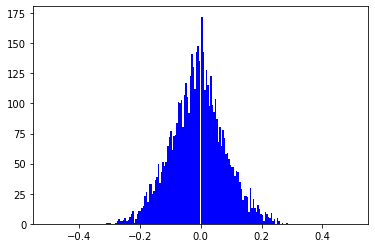

In [18]:
%matplotlib inline
# Order according to column_name
h1 = plt.hist(sum_vol_list[0].np.flatten()-sum_vol_list[-1].np.flatten(), range=(0.001, 0.5), bins=100, color='b')
h2 = plt.hist(sum_vol_list[0].np.flatten()-sum_vol_list[-1].np.flatten(), range=(-0.5, -0.001), bins=100, color='b')